# 7.5 CNN的实现

SimpleConvNet类

In [1]:
# ch07/simple_convnet.py

import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:


    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """


    # 初始化函数
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):

        # =========STEP 1: 从字典提取初始化参数传入的卷积层超参数=========
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # =========STEP 2: 初始化权重参数=========
        self.params = {}
        # 卷积层权重
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        # 卷积层偏置
        self.params['b1'] = np.zeros(filter_num)
        # 第2个全连接层权重
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        # 第2个全连接层偏置
        self.params['b2'] = np.zeros(hidden_size)
        # 第3个全连接层权重
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        # 第3个全连接层偏置
        self.params['b3'] = np.zeros(output_size)

        # =========STEP 3: 生成必要的层=========
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()
    

    # 进行推理
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    
    # 求损失函数
    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是监督标签
        """
        y = self.predict(x)

        return self.last_layer.forward(y, t)

        
    # 记录准确度
    def accuracy(self, x, t, batch_size=100):

        # t是独热数据
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
        
    
    # 数值微分求梯度
    def numerical_gradient(self, x, t):

        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads


    # 反向传播求梯度
    def gradient(self, x, t):

        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """

        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)


    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]
            

利用上述SimpleConvNet学习MNIST数据集

train loss:2.2996494324897383
=== epoch:1, train acc:0.196, test acc:0.21 ===
train loss:2.298931521442355
train loss:2.2946946590470367
train loss:2.2907262436808855
train loss:2.285249313201943
train loss:2.2745529530855895
train loss:2.2713504291915614
train loss:2.247148826588596
train loss:2.2329943737818185
train loss:2.209616635202415
train loss:2.1870572055102686
train loss:2.1335222098199504
train loss:2.1113778596356982
train loss:2.084480533919541
train loss:2.029303601675428
train loss:1.9838462022645404
train loss:1.9917375861658473
train loss:1.8924265038129462
train loss:1.8161865005993436
train loss:1.7121498096217074
train loss:1.6221198676582307
train loss:1.5863546442349823
train loss:1.4687680406236978
train loss:1.3914301511874099
train loss:1.4001919455996423
train loss:1.2629419283837198
train loss:1.1856838028541083
train loss:1.0784147056443443
train loss:0.9083060700680146
train loss:1.1942763537515517
train loss:0.9731555686044246
train loss:1.089739825844901

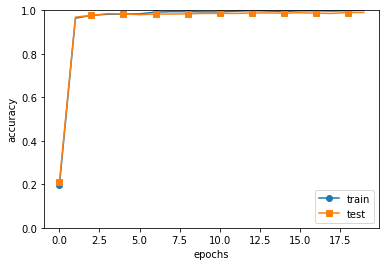

In [2]:
# ch07/train_convnet.py

import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()